# Deep Learning Project

## Image Caption Generation

### Introduction
Image Caption generation is a challenging problem in AI that connects computer vision and NLP where a textual description must be generated for a given photograph. In General Sense for a given image as input, our model describes the exact description of an Image. It requires both image understanding from the domain of computer vision which Convolution Neural Network and a language model from the field of Natural language processing.
It is important to assume and test multiple ways to frame a given predictive modeling problem and there are indeed many ways to frame the problem of generating captions for photographs. 

So Basically what our model does is when we pass an image to our CNN and RNN combined architecture then it will generate the natural description of the image using NLP.

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import nltk
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import torch.nn.functional as F
torch.cuda.empty_cache()

# this file is located in pytorch tutorial/image
# captioning which we pull from git remember
import sys
sys.path.append('C:/Deep Learning/Projects/Code')  # Add once at the start

# Now import normally
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Function to Load and Resize the Image
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

# Model paths
ENCODER_PATH = 'C:/Deep Learning/Projects/Code/Image Caption Generation/Model/encoder-5-3000.pkl'
DECODER_PATH = 'C:/Deep Learning/Projects/Code/Image Caption Generation/Model/decoder-5-3000.pkl'
VOCAB_PATH = 'C:/Deep Learning/Projects/Code/Image Caption Generation/vocab.pkl'

# Constants
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1

In [12]:
def beam_search(decoder, features, vocab, beam_width=5, max_len=20):
    """
    Implements beam search for better caption generation.
    
    Args:
        decoder: DecoderRNN model
        features: Encoded image features from CNN (1, embed_size)
        vocab: Vocabulary wrapper
        beam_width: Number of beams to keep track of
        max_len: Maximum length of the caption
        
    Returns:
        best_caption: The caption with highest probability
    """
    # Move tensors to the same device as the model
    device = next(decoder.parameters()).device
    
    k = beam_width
    vocab_size = len(vocab)
    
    # Get vocabulary start and end tokens
    start_token = vocab.word2idx['<start>']
    end_token = vocab.word2idx['<end>']
    
    # Initialize the hidden state
    states = None
    
    # Start with a single beam containing the start token
    seqs = torch.LongTensor([[start_token]]).to(device)
    top_k_scores = torch.zeros(1, 1).to(device)
    
    # For the first step, use features directly
    inputs = features.unsqueeze(1)  # (1, 1, embed_size)
    
    # Complete sequences and their scores
    complete_seqs = []
    complete_seqs_scores = []
    
    # Start beam search
    for step in range(max_len):
        # Get the number of sequences currently being processed
        curr_batch_size = inputs.size(0)
        
        # Forward pass through decoder
        hiddens, states = decoder.lstm(inputs, states)
        outputs = decoder.linear(hiddens.squeeze(1))  # (batch_size, vocab_size)
        
        # Get scores for next words
        scores = F.log_softmax(outputs, dim=1)  # (batch_size, vocab_size)
        
        if step == 0:
            # For the first step, we'll consider only the first beam's scores
            # and expand to k sequences
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
            
            # Create k sequences by appending each top word to the start token
            seqs = torch.LongTensor([[start_token, w.item()] for w in top_k_words]).to(device)
            
            # Prepare hidden state for expansion to k beams
            if isinstance(states, tuple):  # LSTM states (h, c)
                h, c = states
                h = h.repeat(1, k, 1)
                c = c.repeat(1, k, 1)
                states = (h, c)
        else:
            # Add the log probabilities to current scores
            # scores is (curr_batch_size, vocab_size)
            # top_k_scores is (curr_batch_size)
            # We need to reshape top_k_scores to (curr_batch_size, 1) for broadcasting
            scores = top_k_scores.unsqueeze(1) + scores
            
            # Flatten and find top k scores across all beams
            if step == 1:
                # For step 1, we have exactly k beams
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
            else:
                # For later steps, we may have fewer than k beams due to completions
                # But we still want k total beams if possible
                top_k_scores, top_k_words = scores.view(-1).topk(min(k, scores.numel()), 0, True, True)
            
            # Convert flat indices to beam and word indices
            prev_word_inds = top_k_words // vocab_size  # Beam index
            next_word_inds = top_k_words % vocab_size   # Word index within beam
            
            # Create new sequences by appending new words to existing sequences
            new_seqs = []
            for i, w in zip(prev_word_inds, next_word_inds):
                new_seqs.append(torch.cat([seqs[i], w.unsqueeze(0)], dim=0))
            seqs = torch.stack(new_seqs)
            
            # Reorder the hidden states to match the beam order
            if isinstance(states, tuple):  # LSTM states (h, c)
                h, c = states
                h = h.index_select(1, prev_word_inds)
                c = c.index_select(1, prev_word_inds)
                states = (h, c)
        
        # Check which sequences are complete (reached <end> token)
        is_end = seqs[:, -1] == end_token
        
        # Add complete sequences to our results
        for idx in range(len(is_end)):
            if is_end[idx]:
                # Add this sequence and its score to our complete list
                seq = seqs[idx].clone()  # Get the completed sequence
                score = top_k_scores[idx].clone()  # Get its score
                complete_seqs.append(seq)
                complete_seqs_scores.append(score)
        
        # If all k beams are finished, break
        if len(complete_seqs) >= k:
            break
            
        # Keep only incomplete sequences
        incomplete_inds = ~is_end
        if sum(incomplete_inds) == 0:
            # All sequences are complete
            break
        
        # Update variables to keep only incomplete sequences
        seqs = seqs[incomplete_inds]
        top_k_scores = top_k_scores[incomplete_inds]
        
        # Update states
        if isinstance(states, tuple):
            h, c = states
            h = h[:, incomplete_inds]
            c = c[:, incomplete_inds]
            states = (h, c)
        
        # Prepare inputs for the next step - embedding of last word
        last_words = seqs[:, -1]
        inputs = decoder.embed(last_words).unsqueeze(1)  # (batch_size, 1, embed_size)
        
        # Update k to the number of remaining sequences
        k = sum(incomplete_inds)
    
    # If we have completed sequences, return the best one
    if complete_seqs:
        # Convert tensor to list for easy comparison
        complete_seqs_scores = [score.item() for score in complete_seqs_scores]
        best_idx = complete_seqs_scores.index(max(complete_seqs_scores))
        best_seq = complete_seqs[best_idx]
    else:
        # If no sequence is complete, return the current best one
        best_idx = top_k_scores.argmax().item()
        best_seq = seqs[best_idx]
    
    # Convert sequence of indices to words
    words = []
    for idx in best_seq:
        idx_item = idx.item()
        if idx_item == start_token:  # Skip start token
            continue
        if idx_item == end_token:  # Stop at end token
            break
        words.append(vocab.idx2word[idx_item])
    
    return ' '.join(words)

In [13]:
def PretrainedResNetBeamSearch(image_path, encoder_path=ENCODER_PATH,
                    decoder_path=DECODER_PATH,
                    vocab_path=VOCAB_PATH,
                    embed_size=EMBED_SIZE,
                    hidden_size=HIDDEN_SIZE,
                    num_layers=NUM_LAYERS,
                    beam_width=5):
    
    # Image preprocessing
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                    (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # Build models
    # eval mode (batchnorm uses moving mean/variance)
    encoder = EncoderCNN(embed_size).eval()
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    
    # Move models to device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path, map_location=device))
    decoder.load_state_dict(torch.load(decoder_path, map_location=device))
    
    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate a caption from the image
    feature = encoder(image_tensor)
    
    # Use beam search instead of greedy decoding
    caption = beam_search(decoder, feature, vocab, beam_width=beam_width)
    
    # Format the caption - similar to your original code
    sentence = caption.title()
    
    # Return the generated caption and the image
    image = Image.open(image_path)
    return sentence, image

A Red Double Decker Bus Driving Down A Street .


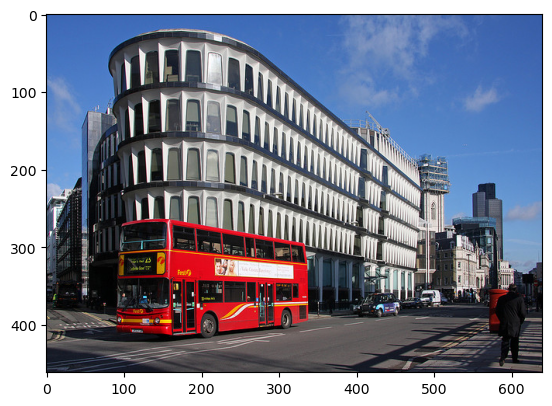

In [25]:
image_path = 'C:/Deep Learning/coco/images/train2014/COCO_train2014_000000002089.jpg'
predicted_label, image = PretrainedResNetBeamSearch(image_path=image_path, beam_width=5)
plt.imshow(image)
print(predicted_label)